In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math

from assignment2 import image,keypoints,match

In [2]:
img_dir = './project_images/'

In [3]:
os.listdir(img_dir)

['MelakwaLake1.png',
 'Rainier6.png',
 'ND2.png',
 'Pergola5.jpg',
 'Pergola3.jpg',
 'Hanging1.png',
 'Rainier4.png',
 'Stitched.png',
 'MelakwaLake3.png',
 'MelakwaLake2.png',
 'AllStitched.png',
 'Pergola2.jpg',
 'Pergola6.jpg',
 'MelakwaLake4.png',
 'ND1.png',
 'Rainier1.png',
 'Pergola4.jpg',
 'Rainier3.png',
 'Rainier5.png',
 'Pergola1.jpg',
 'Rainier2.png',
 'Boxes.png',
 'Hanging2.png']

# Step1
finding keypoints using Harris corner detector <br/>
Using keypoints class from assignment2

100%|██████████| 388/388 [00:01<00:00, 345.71it/s]


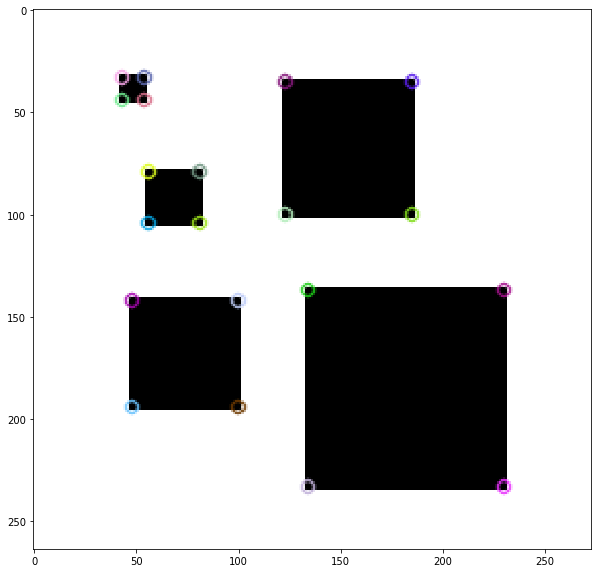

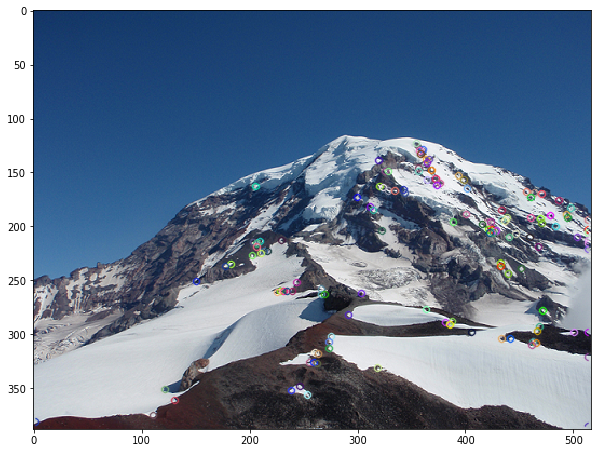

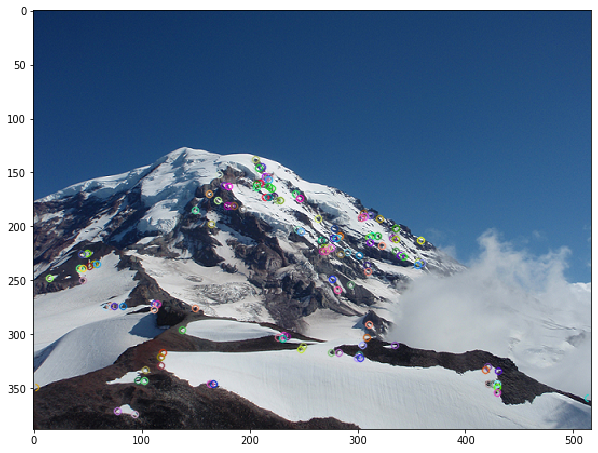

In [4]:
part1 = ['Boxes.png' ,'Rainier1.png', 'Rainier2.png']
thresh = [1.5,0.1,0.1]
res_names = ['1a.png','2a.png','3a.png']
for i,name in enumerate(part1):
    # loading image
    img = image(cv.imread(os.path.join(img_dir,name)))
    #find keypoints using Harris corner detector
    kp = keypoints(img,harris_thresh=thresh[i],nonmax='default')
    #show and saving the results
    plt.figure(figsize=(10,10))
    plt.imshow(cv.cvtColor(kp.show_keypoints(), cv.COLOR_BGR2RGB));
    cv.imwrite(os.path.join('./results',res_names[i]),kp.show_keypoints());

# Step2

True

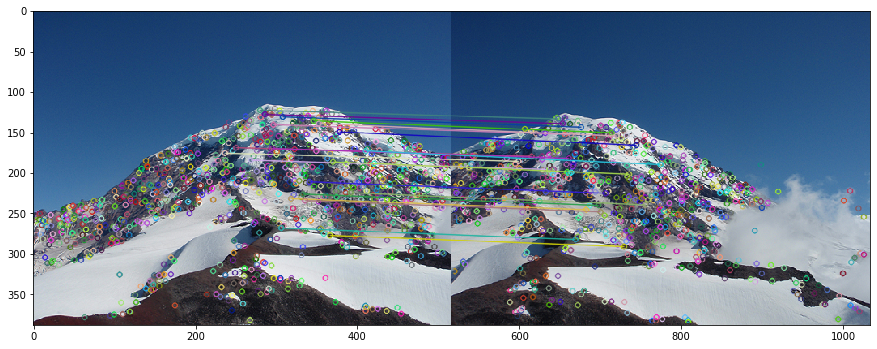

In [5]:
ratio_test_thresh = .01
#creating SIFT
sift = cv.xfeatures2d.SIFT_create()
#loading images
img1 = cv.imread(os.path.join(img_dir,'Rainier1.png'))
img2 = cv.imread(os.path.join(img_dir,'Rainier2.png'))
#extracting keypoints and descriptors using SIFT
kp1 , des1 = sift.detectAndCompute(img1,None)
kp2 , des2 = sift.detectAndCompute(img2,None)
#matching descriptors of Rainier1 and Rainier2
matched = match(des1, des2, threshold=ratio_test_thresh, mode='ratio_test')
#converting matched from numpy array to match datatype of opencv
dmatch = [cv.DMatch(matched[i, 0], matched[i, 1], 0) for i in range(matched.shape[0])]
#producing coupled images with matches as lines
output = cv.drawMatches(img1, kp1, img2 ,kp2 , dmatch, None)
#show and saving result
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
cv.imwrite(os.path.join('./results','2.png'),output)

# Step3

In [6]:
def project(x,y,H):
    """
    project (x,y) using H as a transformation matrix
    """
    p1 = np.array([x,y,1]).reshape((3,1))
    p2 = np.matmul(H,p1)
    return p2[0]/p2[2] , p2[1]/p2[2]

In [7]:
def computeInlierCount(H,matches,kp1,kp2,inlierThreshold):
    """
    Finding how many matches are inliers w.r.t H
    """
    inlierCount = 0
    inliers = []
    for match in matches:
        x,y = project(kp1[match[0]][0],kp1[match[0]][1],H[0])
        if math.sqrt((x-kp2[match[1]][0])**2 + (y-kp2[match[1]][1])**2) < inlierThreshold:
            inlierCount +=1
            inliers.append(match)
    if inlierCount>0:
        return inlierCount , np.stack(inliers)
    else:
        return inlierCount , None

In [8]:
def RANSAC(matches,kp1,kp2,numIterations=1000,inlierThreshold=0.1):
    """
    RANdom SAmple Consensus
    """
    best = 0
    #finding inliers
    for i in range(numIterations):
        #choose 4 random match
        samples = np.random.choice(matches.shape[0],size=4,replace=False)
        #find homography of selected matches
        H = cv.findHomography(kp1[matches[samples,0]],kp2[matches[samples,1]],method=0)
        #calculating inliers count using homography of selected matches
        inlierCount,inliers = computeInlierCount(H,matches,kp1,kp2,inlierThreshold)
        if inlierCount > best:
            best = inlierCount
            best_inliers = inliers
    #find homography with respect to all of the inliers
    best_H = cv.findHomography(kp1[best_inliers[:,0]],kp2[best_inliers[:,1]],method=0)
    return best_H[0] , np.linalg.inv(best_H[0]) , best_inliers

inliers: 55.0%


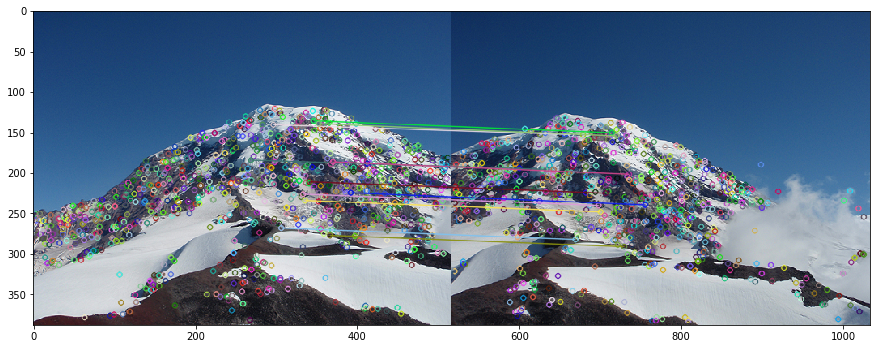

In [9]:
#converting keypoints from opencv objects to a list of coordinates
kp1_ = np.array([kp1[i].pt for i in range(len(kp1))],dtype=np.float32)
kp2_ = np.array([kp2[i].pt for i in range(len(kp2))],dtype=np.float32)
#Using RANSAC to find homography
H,H_inv,inliers = RANSAC(matched,kp1_,kp2_)
print(f'inliers: {inliers.shape[0]*100/matched.shape[0]}%')
#Casting inliers to opencv match and producing matched output
inliers_ = [cv.DMatch(inliers[i, 0], inliers[i, 1], 0) for i in range(inliers.shape[0])]
output = cv.drawMatches(img1, kp1, img2 ,kp2 , inliers_, None)
#show and saving the result
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
cv.imwrite(os.path.join('./results','3.png'),output);

# Step4

In [10]:
def calc_stitch_dims(img1,img2,H):
    """
    find dimensions of stitched image of image1 and image2
    """
    w,h,_  = img2.shape
    #calculting img2 corners
    im2_corners = [[0,0],[0,h],[w,0],[w,h]]
    projected_corners = []
    # projecting img2 corners using H
    for corner in im2_corners:
        y,x = project(corner[1],corner[0],H)
        projected_corners.append([x[0],y[0]])
    # calculating img1 corners
    w,h,_ = img1.shape
    im1_corners = np.stack([[0,0],[0,h],[w,0],[w,h]])
    #converting list to numpy array
    projected_corners = np.stack(projected_corners)
    #stacking img1 and img2 prjected corners
    corners = np.concatenate((projected_corners,im1_corners))
    #upper left corner
    min_p = np.min(corners,axis=0)
    #lower right corner
    max_p = np.max(corners,axis=0)
    # img1 starting point
    s_w = abs(min_p[0])
    s_h = abs(min_p[1])
    # dimensions
    dims = max_p - min_p
    return math.ceil(dims[0]),math.ceil(dims[1]),math.ceil(s_w),math.ceil(s_h)

In [11]:
def stitch(img1,img2,H,H_inv):
    """
    stitch two image using H and H inverse
    """
    # finding stitched image results and img1 location in stitched image
    w,h,s_w,s_h = calc_stitch_dims(img1,img2,H_inv)
    # making stitched image
    stitchedImage = np.zeros((w,h,3),dtype=np.uint8)
    
    w,h,_ = stitchedImage.shape
    w1,h1,_ = img1.shape
    w2,h2,_ = img2.shape
    # copying img1 to its position in stitched image
    stitchedImage[s_w:s_w+w1,s_h:s_h+h1,:] = img1
    
    # iterate over stitched image
    for i in range(w):
        for j in range(h):
            # projecting pixel of stitched image to img2
            y,x = project(j-s_h,i-s_w,H)
            # find in projected point lies into img2 dimensions
            if x>= 0 and x<=img2.shape[0] and y>=0 and y<=img2.shape[1]:
                #find value of pixel from img2 using bilinear interpolation
                patch = cv.getRectSubPix(img2,patchSize=(1,1),center=(y,x))
                # center-weight blending (Extra credit 4)
                if (stitchedImage[i,j] > 0).any():
                    blending_coef1 = 1
                    blending_coef1 *= 1-(abs(x-w2/2))/(w2/2)
                    blending_coef1 *= 1-(abs(y-h2/2))/(h2/2)
                    blending_coef2 = 1
                    blending_coef2 *= 1-(abs((i-s_w)-(w1/2)))/(w1/2)
                    blending_coef2 *= 1-(abs((j-s_h)-(h1/2)))/(h1/2)
                    stitchedImage[i,j] = (blending_coef2/(blending_coef1+blending_coef2)) * stitchedImage[i,j] + (blending_coef1/(blending_coef1+blending_coef2))*patch[0][0]
                else:
                    stitchedImage[i,j] = patch[0][0]
    return stitchedImage

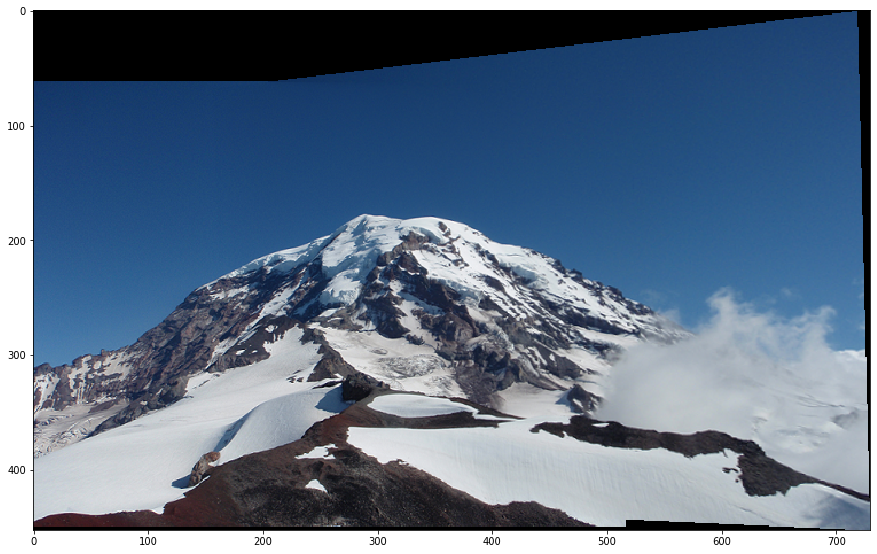

In [12]:
stitched = stitch(img1,img2,H,H_inv)
#show and saving the result
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(stitched, cv.COLOR_BGR2RGB))
cv.imwrite(os.path.join('./results','4.png'),stitched);

# Extra Credit 1

In [13]:
class node:
    """
    contains image and its keypoints and descriptor
    """
    def __init__(self,img):
        self.img = img
        sift = cv.xfeatures2d.SIFT_create()
        kp , self.desc = sift.detectAndCompute(img,None)
        self.kp = np.array([kp[i].pt for i in range(len(kp))],dtype=np.float32)
    def kp(self):
        return self.kp

In [30]:
class match_set:
    """
    matches two image node
    """
    def __init__(self,node1,node2,match_thresh =.5):
        self.node1 = node1
        self.node2 = node2
        self.matched = match(self.node1.desc,self.node2.desc,threshold = match_thresh)
        self.H = None
        self.H_inv = None
        self.inliers = None
        
    def matches_count(self):
        """
        return number of matched keypoints
        """
        if self.matched is not None:
            return self.matched.shape[0]
        else:
            return 0
    
    def inliers_count(self):
        """
        return number of inlier keypoints found using RANSAC
        """
        if self.inliers is not None:
            return self.inliers.shape[0]
        else:
            return 0
    
    def RANSAC(self,numIterations=1000,inlierThreshold=0.2):
        best = 0
        for i in range(numIterations):
            samples = np.random.choice(self.matches_count(),size=4,replace=False)
            H = cv.findHomography(self.node1.kp[self.matched[samples,0]],self.node2.kp[self.matched[samples,1]],method=0)
            inlierCount,inliers = computeInlierCount(H,self.matched,self.node1.kp,self.node2.kp,inlierThreshold)
            if inlierCount > best:
                best = inlierCount
                best_inliers = inliers
        best_H = cv.findHomography(self.node1.kp[best_inliers[:,0]],self.node2.kp[best_inliers[:,1]],method=0)
        self.H = best_H[0]
        self.H_inv = np.linalg.inv(best_H[0])
        self.inliers = best_inliers
        return self.H , self.H_inv , self.inliers
    
    def stitch(self):
        if self.H is None:
            H,H_inv,_ = self.RANSAC()
            self.H = H
            self.H_inv = H_inv
        img1 = self.node1.img
        img2 = self.node2.img
        w,h,s_w,s_h = calc_stitch_dims(img1,img2,self.H_inv)
        stitchedImage = np.zeros((w,h,3),dtype=np.uint8)
        w,h,_ = img1.shape
        stitchedImage[s_w:s_w+w,s_h:s_h+h,:] = img1
        w,h,_ = stitchedImage.shape
        
        w1,h1,_ = img1.shape
        w2,h2,_ = img2.shape
        for i in range(w):
            for j in range(h):
                y,x = project(j-s_h,i-s_w,self.H)
                if x>= 0 and x<=img2.shape[0] and y>=0 and y<=img2.shape[1]:
                    patch = cv.getRectSubPix(img2,patchSize=(1,1),center=(y,x))
                    if (stitchedImage[i,j] > 0).any():
                        blending_coef1 = 1
                        blending_coef1 *= 1-(abs(x-w2/2))/(w2/2)
                        blending_coef1 *= 1-(abs(y-h2/2))/(h2/2)
                        blending_coef2 = 1
                        blending_coef2 *= 1-(abs((i-s_w)-(w1/2)))/(w1/2)
                        blending_coef2 *= 1-(abs((j-s_h)-(h1/2)))/(h1/2)
                        stitchedImage[i,j] = (blending_coef2/(blending_coef1+blending_coef2)) * stitchedImage[i,j] + (blending_coef1/(blending_coef1+blending_coef2))*patch[0][0]
                    else:
                        stitchedImage[i,j] = patch[0][0]
        return stitchedImage

In [27]:
def stitch_all(img_set,matches_thresh = 20):
    """
    stitch all of the images in the list
    """
    #set result to be the first image
    Allstitched = img_set[0]
    #remove first image from the list
    img_set.pop(0)
    step=0
    #iterate over images list until all images are merged into a panorama
    while len(img_set) > 0:
        step +=1
        best = 0
        # find best match to the stitched image
        for i in range(len(img_set)):
            pair = match_set(Allstitched,img_set[i])
            if pair.matches_count() > matches_thresh:
                try:
                    pair.RANSAC()
                except:
                    print('Error')
                print(f'inliers:{pair.inliers_count()}')
                if pair.inliers_count() > best:
                    best_match = pair
                    best_match_index = i
                    print(f'current best:{i}')
        #stitch best match with stitched image
        Allstitched = node(best_match.stitch())
        #remove best match from images list
        img_set.pop(best_match_index)
        #uncomment below line to save every step
        print(step)
        cv.imwrite(os.path.join('./results',f'step{step}.png'),Allstitched.img)
    return Allstitched.img

In [16]:
#loading Rainier images
Rainier_img_set=[]
imgs_name = [os.path.join(img_dir,f'Rainier{i}.png') for i in range(1,7)]
for img in imgs_name:
    print(img)
    im_node = node(cv.imread(img))
    Rainier_img_set.append(im_node)

./project_images/Rainier1.png
./project_images/Rainier2.png
./project_images/Rainier3.png
./project_images/Rainier4.png
./project_images/Rainier5.png
./project_images/Rainier6.png


In [18]:
Rainier = stitch_all(Rainier_img_set)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


1
2
3
4
5


True

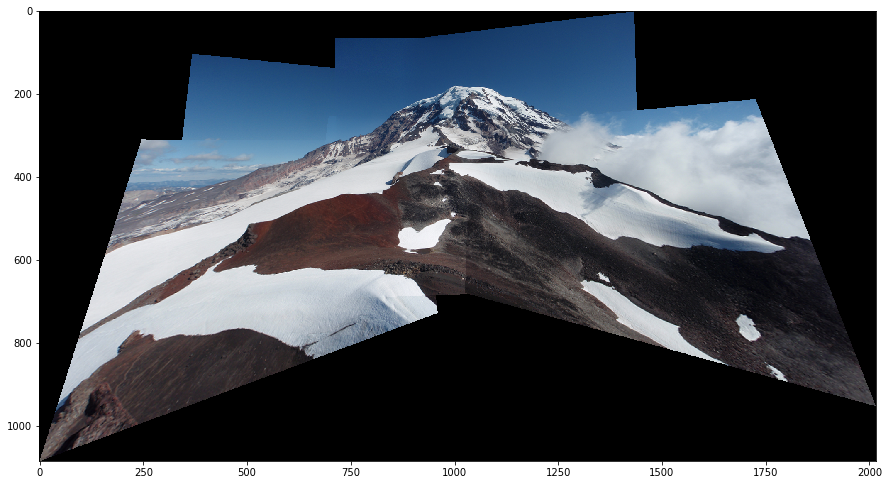

In [19]:
#show and saving the result
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(Rainier, cv.COLOR_BGR2RGB))
cv.imwrite(os.path.join('./results','Allstitched.png'),Rainier)

# Extra Credit 2

In [32]:
#loading Pergola images
Pergola_img_set=[]
imgs_name = [os.path.join(img_dir,f'Pergola{i}.jpg') for i in range(1,7)]
for img in imgs_name:
    print(img)
    #downsize the image by rescaling to 0.4 of the original size
    im_node = node(cv.resize(cv.imread(img),None,fx=.4,fy=.4,interpolation = cv.INTER_CUBIC))
    Pergola_img_set.append(im_node)

./project_images/Pergola1.jpg
./project_images/Pergola2.jpg
./project_images/Pergola3.jpg
./project_images/Pergola4.jpg
./project_images/Pergola5.jpg
./project_images/Pergola6.jpg


In [33]:
Pergola = stitch_all(Pergola_img_set,25)

inliers:12
inliers:12
inliers:13


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


inliers:10
inliers:10
1
inliers:11


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Error
inliers:0
inliers:12
inliers:9
2
inliers:13
inliers:39
inliers:13
3
inliers:15
Error
inliers:0
4
inliers:35
5


True

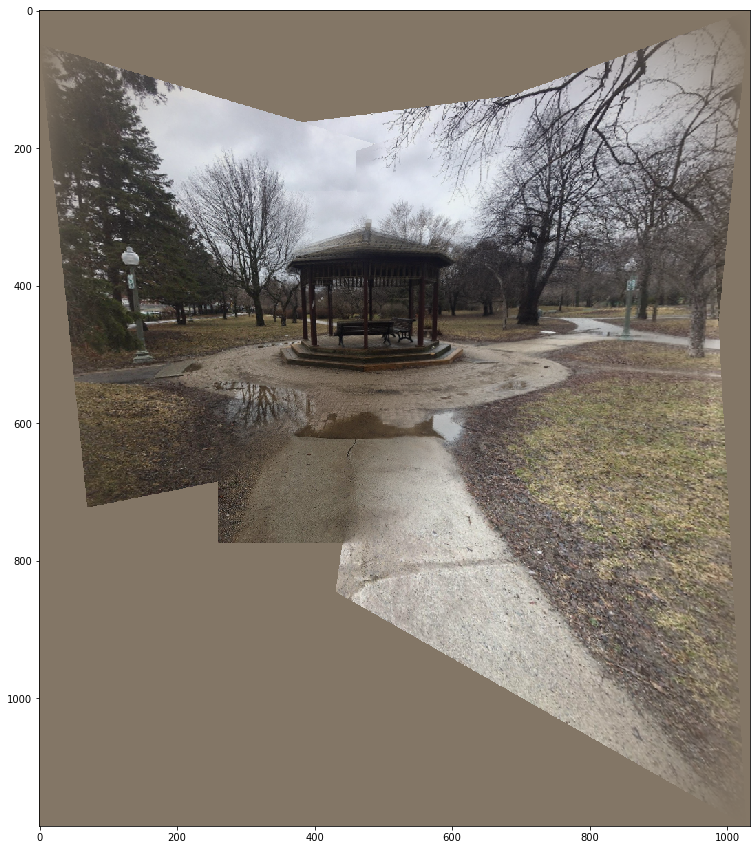

In [34]:
#show and saving the result
plt.figure(figsize=(15,15))
plt.imshow(cv.cvtColor(Pergola, cv.COLOR_BGR2RGB))
cv.imwrite(os.path.join('./results','Pergola_Allstitched.png'),Pergola)